### 环境配置
MindSpore 2.3
MindNLP 0.3.1
Python 3.9

In [1]:
%%capture captured_output
!/home/ma-user/anaconda3/bin/conda create -n python-3.9.0 python=3.9.0 -y --override-channels --channel https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/main
!/home/ma-user/anaconda3/envs/python-3.9.0/bin/pip install ipykernel

In [2]:
import json
import os

data = {
   "display_name": "python-3.9.0",
   "env": {
      "PATH": "/home/ma-user/anaconda3/envs/python-3.9.0/bin:/home/ma-user/anaconda3/envs/python-3.7.10/bin:/modelarts/authoring/notebook-conda/bin:/opt/conda/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/home/ma-user/modelarts/ma-cli/bin:/home/ma-user/modelarts/ma-cli/bin"
   },
   "language": "python",
   "argv": [
      "/home/ma-user/anaconda3/envs/python-3.9.0/bin/python",
      "-m",
      "ipykernel",
      "-f",
      "{connection_file}"
   ]
}

if not os.path.exists("/home/ma-user/anaconda3/share/jupyter/kernels/python-3.9.0/"):
    os.mkdir("/home/ma-user/anaconda3/share/jupyter/kernels/python-3.9.0/")

with open('/home/ma-user/anaconda3/share/jupyter/kernels/python-3.9.0/kernel.json', 'w') as f:
    json.dump(data, f, indent=4)

安装完成后重启kernel，选择python3.9

In [ ]:
%%capture captured_output
!pip uninstall mindspore-gpu -y
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/2.3/MindSpore/unified/x86_64/mindspore-2.3-cp39-cp39-linux_x86_64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install download nltk -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install mindnlp

### 加载数据
首先，加载图像数据集

In [21]:
from datasets import load_dataset
# 数据来源：https://github.com/phelber/EuroSAT
dataset = load_dataset("imagefolder", data_files="EuroSAT_RGB.zip")

Generating train split: 27000 examples [00:05, 4738.60 examples/s]


图像分类任务数据通常包含两类数据：图像和标签

In [22]:
dataset["train"].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], id=None)}

我们首先可视化一个示例

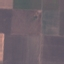

In [23]:
example = dataset["train"][0]
example["image"]

In [24]:
example["label"]

0

当前标签展示为整数，我们可以通过如下的方式将它们转化为真实的分类名

In [35]:
labels = dataset["train"].features["label"].names
labels

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [36]:
id2label = {k:v for k,v in enumerate(labels)}
id2label

{0: 'AnnualCrop',
 1: 'Forest',
 2: 'HerbaceousVegetation',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'PermanentCrop',
 7: 'Residential',
 8: 'River',
 9: 'SeaLake'}

上图图像的标签为'AnnualCrop'

In [29]:
id2label[0]

'AnnualCrop'

### 加载模型
从hub加载模型和处理器

In [16]:
from mindnlp.transformers.models import ConvNextForImageClassification,ConvNextImageProcessor
img_processor = ConvNextImageProcessor.from_pretrained("nielsr/convnext-tiny-finetuned-eurosat")
model = ConvNextForImageClassification.from_pretrained("nielsr/convnext-tiny-finetuned-eurosat")

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.613 seconds.
Prefix dict has been built successfully.
100%|██████████| 266/266 [00:00<00:00, 1.38MB/s]
1.04kB [00:00, 3.59MB/s]                 
100%|██████████| 106M/106M [03:11<00:00, 583kB/s]  


我们取前边的例子进行测试

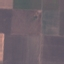

In [30]:
test_image = example["image"].convert("RGB")
test_image

### 图像预处理
使用处理器对测试图像进行预处理，将其转换为张量，并提取预处理后的像素值

In [34]:
pixel_values = img_processor(test_image,return_tensors="ms").pixel_values
pixel_values.shape

(1, 3, 224, 224)

### 前向传播
将预处理后的像素值输入到模型中进行前向传播，提取模型输出的logits

In [33]:
outputs = model(pixel_values)
logits = outputs.logits
logits.shape

(1, 10)

### 预测类别
根据logits得分，获取预测类别。

In [37]:
predicted_class_idx = logits.argmax(-1).item()
model.config.id2label[predicted_class_idx]

'AnnualCrop'